--- ETAPA 3: TREINAMENTO E VALIDAÇÃO COM XGBOOST (LENDO JSON) ---

Carregando 'dados_com_features.json'...
Dados carregados com sucesso.

Preparando os dados para o modelo...
Dados divididos em 36076 para treino e 9019 para teste.

Treinando o Modelo 1: Regressão Logística...
Regressão Logística treinada.

Treinando o Modelo 2: XGBoost...
XGBoost treinado.

--- AVALIAÇÃO DOS MODELOS ---

Resultados da Regressão Logística:
  - AUC-ROC: 0.6239
  - PR-AUC (Average Precision): 0.0888
  - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      8568
           1       0.07      0.58      0.13       451

    accuracy                           0.61      9019
   macro avg       0.52      0.60      0.44      9019
weighted avg       0.92      0.61      0.72      9019


Resultados do XGBoost:
  - AUC-ROC: 0.5938
  - PR-AUC (Average Precision): 0.0826
  - Relatório de Classificação:


c:\Users\erick\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.96      0.66      0.79      8568
           1       0.07      0.48      0.12       451

    accuracy                           0.66      9019
   macro avg       0.51      0.57      0.45      9019
weighted avg       0.92      0.66      0.75      9019


--- SELEÇÃO DO MODELO ---
Vencedor: Regressão Logística

Matriz de Confusão para o modelo Regressão Logística:
Matriz de confusão salva como 'matriz_confusao.png'.

Salvando o modelo vencedor...
Modelo salvo com sucesso como 'modelo_decision_match_ai.joblib'.

--- ETAPA 3 CONCLUÍDA ---


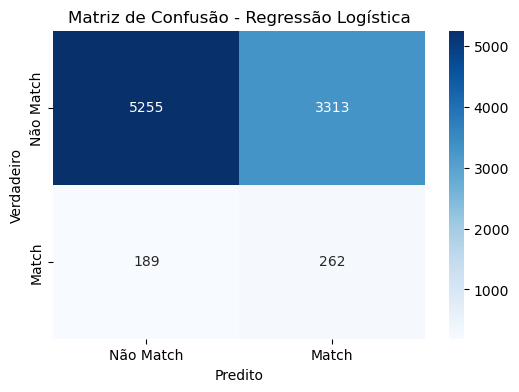

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb  # Importando XGBoost
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

print("--- ETAPA 3: TREINAMENTO E VALIDAÇÃO COM XGBOOST (LENDO JSON) ---")

# Bloco 1: Carregar os dados com features
print("\nCarregando 'dados_com_features.json'...")
try:
    df = pd.read_json('dados_com_features.json', lines=True)
    print("Dados carregados com sucesso.")
except FileNotFoundError:
    print("Erro: O arquivo 'dados_com_features.json' não foi encontrado. Execute a Etapa 2 primeiro.")
    exit()

# Bloco 2: Preparação dos dados para modelagem
print("\nPreparando os dados para o modelo...")
features = ['similaridade_texto', 'match_nivel_ingles', 'match_sap']
X = df[features]
y = df['match']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} para treino e {len(X_test)} para teste.")

# Bloco 3: Treinamento do Modelo 1 - Regressão Logística (Baseline)
print("\nTreinando o Modelo 1: Regressão Logística...")
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)
print("Regressão Logística treinada.")

# Bloco 4: Treinamento do Modelo 2 - XGBoost Classifier
print("\nTreinando o Modelo 2: XGBoost...")
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb_clf.fit(X_train, y_train)
print("XGBoost treinado.")

# Bloco 5: Avaliação dos Modelos no Conjunto de Teste
print("\n--- AVALIAÇÃO DOS MODELOS ---")
y_pred_log_reg_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred_xgb_proba = xgb_clf.predict_proba(X_test)[:, 1]

auc_log_reg = roc_auc_score(y_test, y_pred_log_reg_proba)
pr_auc_log_reg = average_precision_score(y_test, y_pred_log_reg_proba)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
pr_auc_xgb = average_precision_score(y_test, y_pred_xgb_proba)

print("\nResultados da Regressão Logística:")
print(f"  - AUC-ROC: {auc_log_reg:.4f}")
print(f"  - PR-AUC (Average Precision): {pr_auc_log_reg:.4f}")
print("  - Relatório de Classificação:")
y_pred_log_reg = log_reg.predict(X_test)
print(classification_report(y_test, y_pred_log_reg))

print("\nResultados do XGBoost:")
print(f"  - AUC-ROC: {auc_xgb:.4f}")
print(f"  - PR-AUC (Average Precision): {pr_auc_xgb:.4f}")
print("  - Relatório de Classificação:")
y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

# Bloco 6: Seleção do Modelo e Visualização
print("\n--- SELEÇÃO DO MODELO ---")
if pr_auc_xgb > pr_auc_log_reg:
    print("Vencedor: XGBoost")
    modelo_vencedor = xgb_clf
    nome_modelo = "XGBoost"
else:
    print("Vencedor: Regressão Logística")
    modelo_vencedor = log_reg
    nome_modelo = "Regressão Logística"

print(f"\nMatriz de Confusão para o modelo {nome_modelo}:")
cm = confusion_matrix(y_test, modelo_vencedor.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Match', 'Match'], yticklabels=['Não Match', 'Match'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title(f'Matriz de Confusão - {nome_modelo}')
plt.savefig('matriz_confusao.png')
print("Matriz de confusão salva como 'matriz_confusao.png'.")

# Bloco 7: Serialização do Modelo Vencedor
print("\nSalvando o modelo vencedor...")
joblib.dump(modelo_vencedor, 'modelo_decision_match_ai.joblib')
print("Modelo salvo com sucesso como 'modelo_decision_match_ai.joblib'.")
print("\n--- ETAPA 3 CONCLUÍDA ---")